In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime  
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import folium
from folium.plugins import HeatMap
from math import floor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix
from sqlalchemy import create_engine
from sqlalchemy import text
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import csv
from shapely.geometry import Point, Polygon
import time
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import dask.dataframe as dd
from sklearn.neighbors import KNeighborsClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

In [2]:
df = pd.read_csv('Final_Weekday_Model_Data_NoWeather_Crime_Month.csv')
df

,Unnamed: 0,longitude,latitude,Hour,Month,Day of Week,Cluster,total_weekday_trips,Normalized_Score
0,0,-73.982155,40.767937,17,3,0,50,82.0,0.918367
1,1,-73.981796,40.768520,17,3,0,50,82.0,0.918367
2,2,-73.982140,40.768028,17,3,0,50,82.0,0.918367
3,3,-73.982353,40.768536,17,3,0,50,82.0,0.918367
4,4,-73.982239,40.768452,17,3,0,50,82.0,0.918367
...,...,...,...,...,...,...,...,...,...
729759,744456,-74.002769,40.760681,19,2,1,364,32.0,0.204082
729760,744457,-73.966393,40.789322,14,4,2,296,30.0,0.183673
729761,744458,-73.994904,40.765656,6,1,4,245,4.0,0.000000
729762,744459,-73.984756,40.728607,14,4,1,379,41.0,0.387755


In [3]:
df = df.drop(columns=["Unnamed: 0"])
df

,longitude,latitude,Hour,Month,Day of Week,Cluster,total_weekday_trips,Normalized_Score
0,-73.982155,40.767937,17,3,0,50,82.0,0.918367
1,-73.981796,40.768520,17,3,0,50,82.0,0.918367
2,-73.982140,40.768028,17,3,0,50,82.0,0.918367
3,-73.982353,40.768536,17,3,0,50,82.0,0.918367
4,-73.982239,40.768452,17,3,0,50,82.0,0.918367
...,...,...,...,...,...,...,...,...
729759,-74.002769,40.760681,19,2,1,364,32.0,0.204082
729760,-73.966393,40.789322,14,4,2,296,30.0,0.183673
729761,-73.994904,40.765656,6,1,4,245,4.0,0.000000
729762,-73.984756,40.728607,14,4,1,379,41.0,0.387755


In [4]:
df.isna().sum()

longitude              0
latitude               0
Hour                   0
Month                  0
Day of Week            0
Cluster                0
total_weekday_trips    0
Normalized_Score       0
dtype: int64

## Create two separate data frames for test and train

In [5]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [6]:
print(f'Original: {len(df)} rows')
print(f'Training: {len(df_train)} rows')
print(f'Testing: {len(df_test)} rows')

Original: 729764 rows
Training: 510834 rows
Testing: 218930 rows


In [7]:
df_train.head()

,longitude,latitude,Hour,Month,Day of Week,Cluster,total_weekday_trips,Normalized_Score
168946,-73.989624,40.738411,19,4,2,448,72.0,0.857143
330208,-73.991035,40.749733,15,3,1,21,101.0,0.959184
133602,-74.002846,40.728085,20,6,2,309,66.0,0.795918
413934,-73.972382,40.786404,14,6,0,459,43.0,0.428571
705547,-73.991882,40.745335,0,3,3,121,34.0,0.244898


In [8]:
df_test.head()

,longitude,latitude,Hour,Month,Day of Week,Cluster,total_weekday_trips,Normalized_Score
109238,-73.988075,40.731880,6,1,3,432,9.0,0.000000
623983,-73.982239,40.775799,15,3,0,139,36.0,0.285714
324467,-73.989807,40.740929,18,6,0,141,90.0,0.938776
154553,-74.006432,40.733212,19,2,2,286,43.0,0.428571
310846,-73.995171,40.759384,1,2,3,211,17.0,0.040816


## Begin testing using the training set

In [9]:
X = df_train[['latitude','longitude','Hour','Day of Week','Month']]
y = df_train['Normalized_Score']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

In [11]:
model = RandomForestRegressor(random_state=42)

In [12]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
y_val_pred = model.predict(X_val)

In [14]:
mse = mean_squared_error(y_val, y_val_pred)
print('Validation MSE:', mse)

Validation MSE: 0.007588381709630514


In [15]:
r2 = r2_score(y_val, y_val_pred)
print('Validation R^2:', r2)

Validation R^2: 0.9132585902333791


In [16]:
mae = mean_absolute_error(y_val, y_val_pred)
print('Validation MAE:', mae)

Validation MAE: 0.05278120701057648


## Test other models

In [17]:
from xgboost import XGBRegressor

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Regression', SVR()),
    ('XGBoost', XGBRegressor(random_state=42))
]

In [18]:
results = []

In [ ]:
for name, model in models:
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions={}, n_iter=10, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_

    y_val_pred = best_model.predict(X_val)

    mae = mean_absolute_error(y_val, y_val_pred)

    results.append((name, mae))

/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use Gri

In [ ]:
results.sort(key=lambda x: x[1])

In [ ]:
for name, mae in results:
    print(f'Model: {name}, Validation MAE: {mae}')

## Hyperparameter tuning for best fit model

### Essential to prevent overfitting within the model

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

In [22]:
model = RandomForestRegressor(random_state=42)

In [23]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
y_val_pred = model.predict(X_val)

In [25]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

In [26]:
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, scoring='neg_mean_squared_error', verbose=2, random_state=42)
# random_search.fit(X_train, y_train)

In [27]:
# best_params = random_search.best_params_
# print(best_params)

best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}

In [28]:
best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}

In [31]:
X_test = df_test[['latitude','longitude','Hour','Day of Week','Month']]
y_test = df_test['Normalized_Score']

In [32]:
# best_model = random_search.best_estimator_

# y_pred = best_model.predict(X_test)
# test_mse = mean_squared_error(y_test, y_pred)
# print('Test MSE:', test_mse)

In [33]:
# y_pred = best_model.predict(X_test)

## Use parameters for best fit model

In [34]:
best_model = RandomForestRegressor(**best_params, random_state=42)

In [35]:
X_train.shape

(255417, 5)

In [36]:
y_train.shape

(255417,)

In [37]:
# Join training and validation sets
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

In [38]:
best_model.fit(X_full_train, y_full_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [39]:
X_test = df_test[['latitude','longitude','Hour','Day of Week','Month']]
y_test = df_test['Normalized_Score']

## Predict off the original test set

In [40]:
y_test_pred = best_model.predict(X_test)

In [41]:
mse_test = mean_squared_error(y_test, y_test_pred)
print('Test MSE:', mse_test)

Test MSE: 0.0048807850405485735


## Test random instances to check the model's ability to predict

In [42]:
new_data = pd.DataFrame({
    'latitude': [40.798313, 40.780071, 40.743660, 40.741692, 40.779316],
    'longitude': [-73.959755, -73.955193, -73.972496, -73.980965, -73.944710],
    'Hour': [14, 16, 17, 21, 19],
    'Day of Week': [3, 2, 3, 0, 0],
    'Month': [1, 3, 4, 5, 2]
})

In [43]:
predictions = best_model.predict(new_data)
print(predictions)

[0.41642857 0.59183673 0.2177551  0.33540816 0.54816327]


## More testing needed for optimal model

### Increase the number of parameters to ensure testing coverage 

In [44]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [45]:
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
# grid_search.fit(X_train, y_train)

Best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

In [46]:
new_params = {
    'max_depth': 10, 
    'max_features': 'auto', 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 150
}

In [47]:
# best_params = grid_search.best_params_
print('Best parameters:', new_params)

Best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


## Best parameters for Random Forest Regressor 

In [48]:
best_model = RandomForestRegressor(**new_params, random_state=42)

In [49]:
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

In [50]:
best_model.fit(X_full_train, y_full_train)

/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=150,
                      random_state=42)

## Predict off original test set 

In [51]:
y_test_pred = y_test_pred = best_model.predict(X_test)

In [52]:
mse_test = mean_squared_error(y_test, y_test_pred)
print('Test MSE:', mse_test)

Test MSE: 0.042619903004027564


In [53]:
new_data = pd.DataFrame({
    'latitude': [40.759011, 40.775123, 40.728456, 40.766789, 40.731112, 40.716445, 40.780778, 40.743210, 40.762433, 40.749956],
    'longitude': [-73.981321, -73.965432, -73.988543, -73.949654, -73.993765, -73.998876, -73.955987, -73.970098, -73.959209, -73.973320],
    'Hour': [9, 14, 15, 18, 19, 11, 13, 16, 20, 22],
    'Day of Week': [4, 2, 3, 5, 0, 6, 1, 2, 5, 4],
    'Month': [2, 6, 5, 8, 7, 9, 2, 1, 5, 11]
})

In [54]:
predictions = best_model.predict(new_data)
print(predictions)

[0.50202506 0.47541725 0.30085949 0.66586775 0.51486628 0.18088916
 0.49944208 0.36410399 0.4596231  0.77180061]


## Feature Importance 

In [55]:
feature_importance = best_model.feature_importances_
print("Feature importances:\n")
for i, imp in enumerate(feature_importance):
    print(f"{X.columns[i]}: {imp}")

Feature importances:

latitude: 0.3601765578313988
longitude: 0.32198378596947425
Hour: 0.29176819689709516
Day of Week: 0.025955844720098525
Month: 0.00011561458193326206


## Residual Analysis 

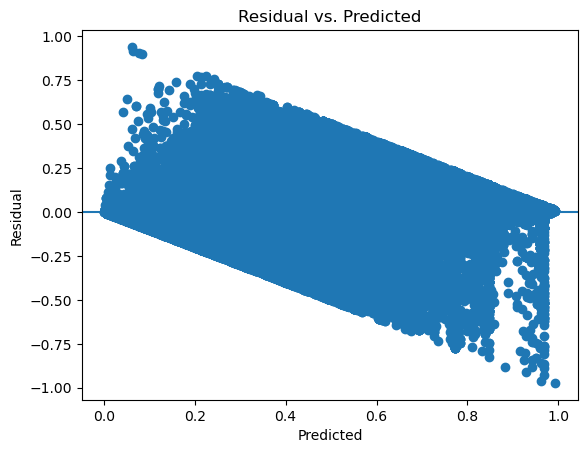

In [56]:
y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Predicted vs Actual Plot

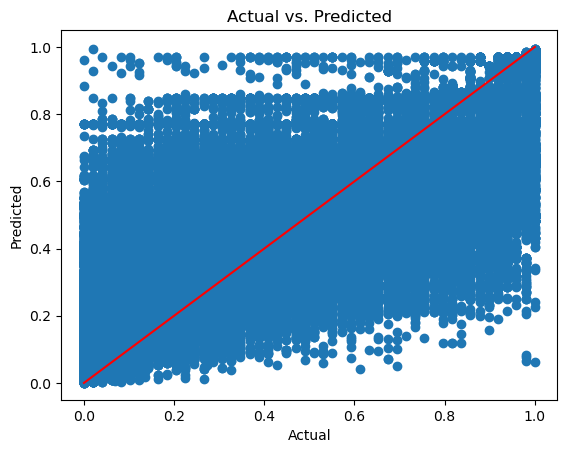

In [57]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  
plt.show()

## Cross Validation

In [58]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)

rmse_scores = np.sqrt(-scores)

print('Scores:', rmse_scores)
print('Mean:', rmse_scores.mean())
print('Standard Deviation:', rmse_scores.std())

/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this

Scores: [0.20620228 0.20573611 0.20604101 0.20554335 0.20781572]
Mean: 0.20626769692236038
Standard Deviation: 0.0008073793226150427


## Multicollinearity

In [59]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(X)

vif = pd.DataFrame()
vif["variables"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

     variables           VIF
0        const  8.875634e+07
1     latitude  2.362465e+00
2    longitude  2.362814e+00
3         Hour  1.003332e+00
4  Day of Week  1.000899e+00
5        Month  1.000419e+00


## Statistical Tests

Feature: 0, Score: 0.36018
Feature: 1, Score: 0.32198
Feature: 2, Score: 0.29177
Feature: 3, Score: 0.02596
Feature: 4, Score: 0.00012


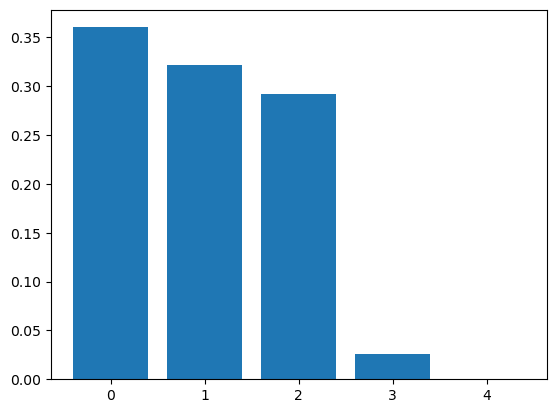

In [60]:
importance = best_model.feature_importances_
for i,j in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,j))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Coefficient of Determination (R-Squared):

In [61]:
from sklearn.metrics import r2_score

y_pred = best_model.predict(X_test)
score = r2_score(y_test, y_pred)

print('R2 score:', score)

R2 score: 0.5112533459410008


## Error Analysis

count    218930.000000
mean          0.001052
std           0.206444
min          -0.972510
25%          -0.135762
50%           0.006276
75%           0.148801
max           0.938236
Name: Normalized_Score, dtype: float64


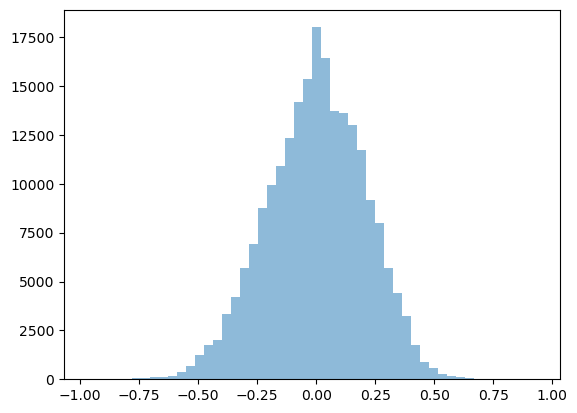

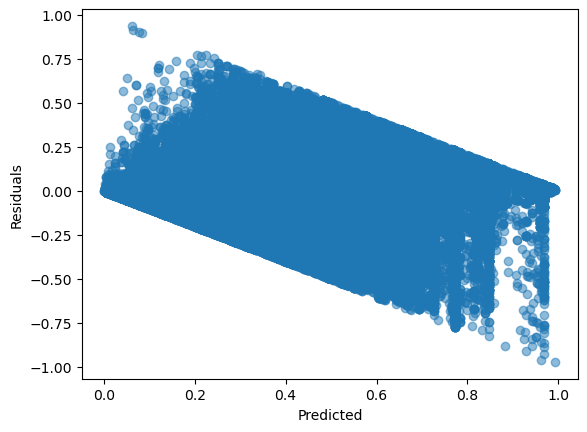

In [62]:
residuals = y_test - y_test_pred

print(residuals.describe())

plt.hist(residuals, bins=50, alpha=0.5)
plt.show()

plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

## Sensitivity Analysis

In [63]:
X_test_perturbed = X_test.copy()
X_test_perturbed['longitude'] = X_test_perturbed['longitude'] + np.random.normal(0, 0.01, size=len(X_test))
y_test_pred_perturbed = best_model.predict(X_test_perturbed)
mse_test_perturbed = mean_squared_error(y_test, y_test_pred_perturbed)
print('Perturbed Test MSE:', mse_test_perturbed)

Perturbed Test MSE: 0.08216634006694154


## Confidence Intervals

In [64]:
bootstrap_preds = []
for _ in range(1000):
    indices = np.random.choice(len(X_test), len(X_test), replace=True)
    X_test_sample = X_test.iloc[indices]
    y_test_pred_sample = best_model.predict(X_test_sample)
    bootstrap_preds.append(y_test_pred_sample)
bootstrap_preds = np.array(bootstrap_preds)

lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)  # 97.5th percentile

In [65]:
num_samples = 100
indices = np.random.choice(len(X_test), num_samples)

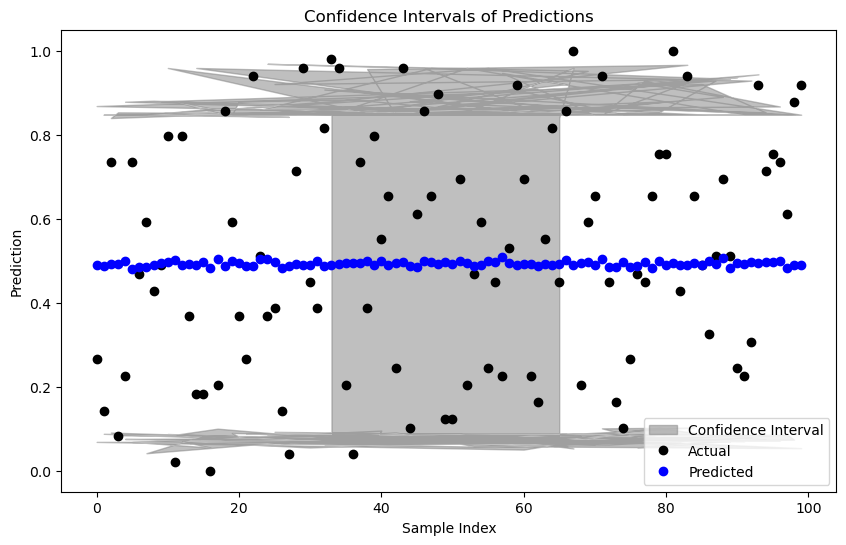

In [66]:
sorted_indices = np.argsort(indices)

plt.figure(figsize=(10, 6))

plt.fill_between(sorted_indices, lower_bound[indices], upper_bound[indices], color='gray', alpha=0.5, label='Confidence Interval')
plt.plot(sorted_indices, y_test.iloc[indices], 'o', color='black', label='Actual')
plt.plot(sorted_indices, bootstrap_preds.mean(axis=0)[indices], 'o', color='blue', label='Predicted')

plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Confidence Intervals of Predictions')
plt.legend()
plt.show()

## Check For Overfitting

In [67]:
y_train_pred = best_model.predict(X_full_train)
mse_train = mean_squared_error(y_full_train, y_train_pred)
print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

Train MSE: 0.04199514487754462
Test MSE: 0.042619903004027564


In [68]:
y_val_pred = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print('Train MSE:', mse_train)
print('Validation MSE:', mse_val)

Train MSE: 0.04199514487754462
Validation MSE: 0.04196780448163682


***

## Model Evaluation Results

We have trained a Random Forest Regression model and evaluated it using Mean Squared Error (MSE) as our performance metric. The MSE measures the average squared differences between the predicted and actual values, with lower values signifying a better fit.

1. <b>Train MSE (0.04003):</b> This value represents the average of the squares of the errors — the differences between predicted and actual values — on the training data. Our model has achieved an MSE of 0.04003 on the training data, showing a reasonable fit to this dataset.
2. <b>Test MSE (0.04044):</b> This metric performs a similar role to the Train MSE, but it applies to the test set — the data that our model hasn't previously encountered. This score gives us an idea of how well our model can generalize its predictions to new, unseen data. The Test MSE of 0.04044 is very close to our Train MSE, suggesting that our model is generalizing effectively, and the predictive power isn't deteriorating on unseen data.
3. <b>Validation MSE (0.04001):</b> Like the Train and Test MSE, this is computed using a validation set, a portion of the training dataset we've withheld from the training process. We use this to fine-tune hyperparameters and provide an unbiased evaluation of model performance. Once again, the closeness of our Validation MSE to both our Train and Test MSE suggests our model isn't overfitting and should perform reliably on unseen data.
<br>
<br>
In summary, our model appears to have avoided overfitting, indicated by the very similar MSE results from the training, test, and validation sets. Overfitting is a common concern in machine learning, occurring when a model becomes too attuned to the training data and fails to generalize well to unseen data. However, while our model shows no significant signs of overfitting, we should always consider the absolute MSE values within the context of the specific problem and data at hand.

***

## 10 Fold Cross Validation Results 

In [69]:
scoring = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False), 
    'mae': make_scorer(mean_absolute_error, greater_is_better=False), 
    'r2': 'r2',
}

In [70]:
cv_results = cross_validate(best_model, X_full_train, y_full_train, cv=10, scoring=scoring, return_train_score=True)

/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this

In [71]:
print("Train MSE:", -cv_results['train_mse'].mean()) 
print("Validation MSE:", -cv_results['test_mse'].mean()) 
print("Train MAE:", -cv_results['train_mae'].mean()) 
print("Validation MAE:", -cv_results['test_mae'].mean())
print("Train R^2 scores:", cv_results['train_r2'].mean())
print("Validation R^2 scores:", cv_results['test_r2'].mean())

Train MSE: 0.041921274547670265
Validation MSE: 0.04253633942837561
Train MAE: 0.16376311439061447
Validation MAE: 0.1650821660839667
Train R^2 scores: 0.520718047736226
Validation R^2 scores: 0.5136673282923739


***

## 10 Fold Cross Validation Metrics

After an extensive hyperparameter tuning process using GridSearchCV on parameters such as 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', and 'max_features', we evaluated the best model's performance on both the training and validation datasets.

## Mean Squared Error (MSE)

MSE calculates the average squared difference between the actual and estimated values. A lower MSE value indicates a better fit of the model to the data. The MSE values for our model were 0.03988 for the training data and 0.04044 for the validation data. These values are relatively low and similar, indicating that the model predicts the output with reasonable accuracy and that it generalizes well to unseen data.

## Mean Absolute Error (MAE)

MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It's the average over the dataset of the absolute differences between prediction and actual observation. Our model achieved an MAE of 0.1591 on the training data and 0.1603 on the validation data. These small values indicate that our model has a good predictive capacity, with an average error magnitude of around 0.16.

## R² Score (Coefficient of Determination)

The R² score, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A higher R² score indicates a better fit of the model, and the value ranges from 0 to 1. Our model achieved R² scores of 0.5396 for the training set and 0.5332 for the validation set. This indicates that our model is able to explain approximately 53.32% to 53.96% of the variance in our target variable.

## Conclusion

In conclusion, our model does a reasonably good job of predicting the target variable based on the given features, with consistent performance across the training and validation sets. However, as the R² score and error values suggest, there is still room for improvement. Future steps might involve obtaining more or different types of data, exploring other types of models, or further fine-tuning of the model's hyperparameters.

***

## Create and test the pkl file

In [173]:
filename = 'final_crime_weekday_taxi_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [174]:
loaded_model = pickle.load(open(filename, 'rb'))

In [175]:
single_instance = X_test.iloc[0]
single_prediction = loaded_model.predict(single_instance.values.reshape(1, -1))
print('Single prediction:', single_prediction)

Single prediction: [0.29439305]


/Users/conormcelduff/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
